# Colormap (AuNRs, length and diameter sweep with Mie-Gans theory)

In [1]:
import numpy as npy
import RefractiveIndex as ri
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import numpy.polynomial.polynomial as poly

#### Cross sections for 41 x 10 nm AuNR

In [2]:
D = 9.5             # Nanorod diameter
L = 41.5            # Nanorod length
AR = L/D            # Nanorod aspect ratio

Vnp = npy.pi*((D*(1e-9)/2)**2)*L*(1e-9)
Req = (3*Vnp/(4*npy.pi))**(1/3)

# Spheroidal properties 
e = npy.sqrt(1 - 1/(AR**2))
Lx = ((1 - e**2)/e**2)*((1/(2*e))*npy.log((1 + e)/(1 - e)) - 1)
Ly = (1 - Lx)/2
Lz = Ly

In [3]:
# Importing NP refractive index

shell_material = 'Au'                                    
core_material = 'Water'
medium_material = 'Water'

drude = False

lambda_min = 450                                         
lambda_max = 950

wl, N, N1, N2, mu1, mu2 = ri.setupRI(shell_material,core_material,medium_material,Req,Req,lambda_min,lambda_max,False,drude)

eps_medium = N**2
eps_np = N2**2

In [4]:
# Wavenumber
k = 2*npy.pi*N/wl

# Spheroidal polarizabilities
alpha_x = Vnp/(Lx + eps_medium/(eps_np - eps_medium))
alpha_y = Vnp/(Ly + eps_medium/(eps_np - eps_medium))
alpha_z = Vnp/(Lz + eps_medium/(eps_np - eps_medium))

# x polarizability correction
alpha_x_rs = alpha_x/(1 - ((k**2)/(4*npy.pi*(L*(1e-9))/2))*alpha_x - (1.0j)*((k**3)/(6*npy.pi))*alpha_x)

# Optical cross sections
Csca = -((k**4)/(6*npy.pi))*(alpha_x_rs**2 + alpha_y**2+ alpha_z**2)
Cabs = k*npy.imag(alpha_x_rs + alpha_y + alpha_z)
Cext = Csca + Cabs

c:\Users\Tulio\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


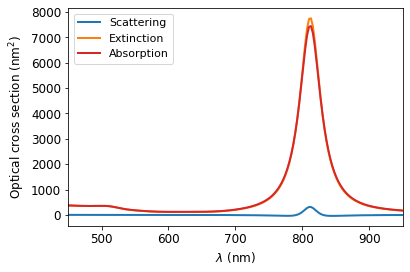

In [5]:
fig1 = plt.figure(1)
ax1 = plt.gca()
lines1 = plt.plot((1e9)*wl,Csca/(1e-18),'tab:blue',(1e9)*wl,Cext/(1e-18),'tab:orange',(1e9)*wl,Cabs/(1e-18),'tab:red',linewidth=2)
plt.ylabel('Optical cross section (nm$^{2}$)',fontsize=12)
plt.xlabel('$\lambda$ (nm)',fontsize=12)
plt.legend(lines1[:4], ['Scattering','Extinction','Absorption'],fontsize=11)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlim([lambda_min,lambda_max])
plt.show()

#### 2D parametric sweep (L and D)

In [6]:
def MieGans(L, D, material,medium):
    AR = L/D
    Vnp = npy.pi*((D*(1e-9)/2)**2)*L*(1e-9)
    Req = (3*Vnp/(4*npy.pi))**(1/3)

    # Spheroidal properties 
    e = npy.sqrt(1 - 1/(AR**2))
    Lx = ((1 - e**2)/e**2)*((1/(2*e))*npy.log((1 + e)/(1 - e)) - 1)
    Ly = (1 - Lx)/2
    Lz = Ly

    # Importing NP refractive index
    shell_material = material                                    
    core_material = medium
    medium_material = medium
    drude = False
    lambda_min = 450                                         
    lambda_max = 950
    wl, N, N1, N2, mu1, mu2 = ri.setupRI(shell_material,core_material,medium_material,Req,Req,lambda_min,lambda_max,True,drude)
    eps_medium = N**2
    eps_np = N2**2

    # Wavenumber
    k = 2*npy.pi*N/wl

    # Spheroidal polarizabilities
    alpha_x = Vnp/(Lx + eps_medium/(eps_np - eps_medium))
    alpha_y = Vnp/(Ly + eps_medium/(eps_np - eps_medium))
    alpha_z = Vnp/(Lz + eps_medium/(eps_np - eps_medium))

    # x polarizability correction
    alpha_x_rs = alpha_x/(1 - ((k**2)/(4*npy.pi*(L*(1e-9))/2))*alpha_x - (1.0j)*((k**3)/(6*npy.pi))*alpha_x)

    # Optical cross sections
    Csca = -((k**4)/(6*npy.pi))*(alpha_x_rs**2 + alpha_y**2+ alpha_z**2)
    Cabs = k*npy.imag(alpha_x_rs + alpha_y + alpha_z)
    Cext = Csca + Cabs

    return wl, Csca, Cabs, Cext, Vnp

In [7]:
L_min = 5
L_max = 150
L_res = 2.5
n_L = int((L_max-L_min)/L_res+1)

D_min = 6
D_max = 50
D_res = 2
n_D = int((D_max-D_min)/D_res+1)

const = (1240e-9)/(2*npy.pi)    # Supporting constant for Jo

x = npy.linspace(L_min,L_max,n_L)
y = npy.linspace(D_min,D_max,n_D)

In [8]:
L = []
D = []
Jo = []
LSPR = []

for m in range(0,len(x)-1):
    for n in range(0,len(y)-1):
        if x[m] > y[n]:
            L = npy.append(L,x[m])
            D = npy.append(D,y[n])
            wl, Csca, Cabs, Cex, Vnp = MieGans(x[m],y[n],'Au','Water')
            pos = Cabs.argmax()
            LSPR = npy.append(LSPR,wl[pos]*(1e9))
            Jo = npy.append(Jo,const*Cabs[pos]/Vnp)

In [9]:
grid_x, grid_y = npy.mgrid[min(D):max(D):n_D*1j,min(L):max(L):n_L*1j]

# LSPR
values = interp.griddata((D, L), LSPR, (grid_x, grid_y), method='cubic')
values2 = npy.transpose(values)

# Jo
values3 = interp.griddata((D, L), Jo, (grid_x, grid_y), method='cubic')
values4 = npy.transpose(values3)

In [10]:
# D_800 = []
# L_800 = []
# LSPR_800 = []
# Jo_800 = []

# for m in range(0,len(grid_x)-1):
#     for n in range(0,len(grid_y)-1):
#         if (values2[m,n]>800-10 and values2[m,n]<800+10):
#             D_800 = npy.append(D_800,grid_y[m,n])
#             L_800 = npy.append(L_800,grid_x[m,n])
#             LSPR_800 = npy.append(LSPR_800,values2[m,n])
#             Jo_800 = npy.append(Jo_800,values2[m,n])

In [11]:
# L_new_800 = npy.linspace(0, 30, num=len(D_800)*50)
# coefs_800 = poly.polyfit(D_800, L_800, 2)
# ffit_800 = poly.polyval(L_new_800, coefs_800)

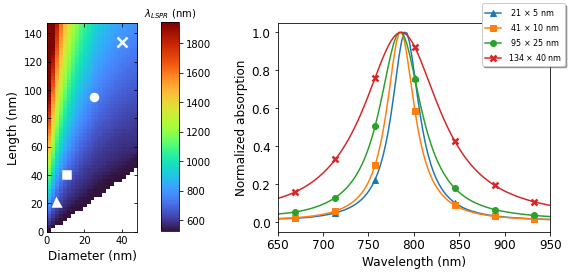

In [12]:
fig1 = plt.figure(constrained_layout=True, figsize=(8.5,3.5))
axs1 = fig1.subplot_mosaic([['Left', 'Right']])

axs1['Left'].xaxis.set_tick_params(which='major', direction='in', top='on')
axs1['Left'].yaxis.set_tick_params(which='major', direction='in', top='on')
imtst = axs1['Left'].imshow(values2, origin='lower', extent=[0, max(D), 0, max(L)], aspect='0.75', cmap=plt.get_cmap('turbo'))
axs1['Left'].plot(5, 21, '^', markersize=7, color='w', mew=2.5)
axs1['Left'].plot(10, 41, 's', markersize=7, color='w', mew=2.5)
axs1['Left'].plot(25, 95, 'o', markersize=7, color='w', mew=2.5)
axs1['Left'].plot(40, 134, 'x', markersize=10, color='w', mew=2.5)
axs1['Left'].set_ylabel('Length (nm)', fontsize=12)
axs1['Left'].set_xlabel('Diameter (nm)', fontsize=12)
cbar1 = fig1.add_axes([0.34, 0.16, 0.03, 0.83])
cbar1 = fig1.colorbar(imtst, cax=cbar1)
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_title('$\lambda_{LSPR}$ (nm)', fontsize=10)

wl, Csca, Cabs, Cex, Vnp = MieGans(21,5,'Au','Water')
p1b1, = axs1['Right'].plot(wl*(1e9), Cabs/max(Cabs), marker = '^', markevery=15, markersize=6, label=' 21 $\\times$ 5 nm')
wl, Csca, Cabs, Cex, Vnp = MieGans(41,10,'Au','Water')
p1b2, = axs1['Right'].plot(wl*(1e9), Cabs/max(Cabs), marker = 's', markevery=15, markersize=6, label=' 41 $\\times$ 10 nm')
wl, Csca, Cabs, Cex, Vnp = MieGans(95,25,'Au','Water')
p1b3, = axs1['Right'].plot(wl*(1e9), Cabs/max(Cabs), marker = 'o', markevery=15, markersize=6, label=' 95 $\\times$ 25 nm')
wl, Csca, Cabs, Cex, Vnp = MieGans(134,40,'Au','Water')
p1b4, = axs1['Right'].plot(wl*(1e9), Cabs/max(Cabs), marker = 'x', markevery=15, markersize=6, mew=2.5, label='134 $\\times$ 40 nm')
axs1['Right'].set_ylabel('Normalized absorption', fontsize=12)
axs1['Right'].set_xlabel('Wavelength (nm)', fontsize=12)
axs1['Right'].tick_params(axis='x', labelsize=12)
axs1['Right'].tick_params(axis='y', labelsize=12)
axs1['Right'].set_xlim([650,950])

plt.figlegend(handles=[p1b1, p1b2, p1b3, p1b4], loc=1, prop={'size': 8}, fancybox=True, shadow=True)

plt.show()

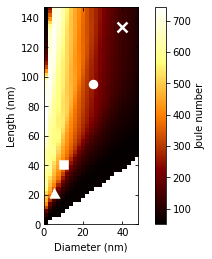

In [13]:
fig2 = plt.figure(2)
ax2 = plt.gca()
ax2.xaxis.set_tick_params(which='major', direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', direction='in', top='on')
plt.imshow(values4, origin='lower', extent=[0, max(D), 0, max(L)], aspect=0.75, cmap=plt.get_cmap('afmhot'))
plt.plot(5, 21, '^', markersize=7, color='w', mew=2.5)
plt.plot(10, 41, 's', markersize=7, color='w', mew=2.5)
plt.plot(25, 95, 'o', markersize=7, color='w', mew=2.5)
plt.plot(40, 134, 'x', markersize=10, color='w', mew=2.5)
plt.ylabel('Length (nm)')
plt.xlabel('Diameter (nm)')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Joule number')
plt.show()